In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
#!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar

In [4]:
#!wget http://download.pytorch.org/tutorial/hymenoptera_data.zip

In [24]:
#!unzip manga.zip

Archive:  manga.zip
  inflating: MangaAdaptaitonScore.csv  


In [5]:
#!tar -xvf images.tar

In [6]:
#!unzip hymenoptera_data.zip

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,)),
])

In [8]:
#今回は自分で用意したデータセットを使うので、パスに注意
train_dataset = datasets.ImageFolder('./dogs/train/', transform=transform)
val_dataset = datasets.ImageFolder('./dogs/val/', transform=transform)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 224, 224])


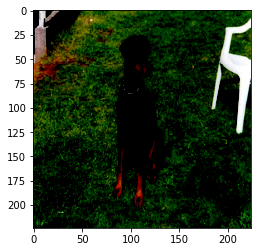

In [10]:
data_iter = iter(train_loader)
imgs, labels = data_iter.next()
print(imgs.size())
data_iter = iter(train_loader)
imgs, labels = data_iter.next()
plt.imshow(imgs[0].permute(1,2,0))

In [11]:
# trainフォルダ内のフォルダ名順にラベルが割り当てられる
labels

tensor([1, 2, 1, 1, 1, 2, 0, 0, 1, 2, 2, 2, 0, 2, 1, 2, 0, 2, 0, 0, 0, 1, 1, 2,
        1, 1, 1, 0, 2, 2, 0, 0])

In [12]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
model.fc = nn.Linear(512, 3)

In [14]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [16]:
#%%time #処理時間計算用

num_epochs = 10
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    model.train()

    for i, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        labels = labels.to(device)
      
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        train_loss += loss.item()
        pred = torch.argmax(outputs, dim=1)
        train_acc += (pred == labels).sum().item()

        loss.backward()
        optimizer.step()
        
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)

    model.eval()
    with torch.no_grad():
      for images, labels in val_loader:
          
          images = images.to(device)
          labels = labels.to(device)

          outputs = model(images)
          loss = criterion(outputs, labels)
          
          val_loss += loss.item()
          pred = torch.argmax(outputs, dim=1)
          val_acc += (pred == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_val_acc = val_acc / len(val_loader.dataset)
        
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

Epoch [1/10], Loss: 0.0253, val_loss: 0.0142, val_acc: 0.9219
Epoch [2/10], Loss: 0.0114, val_loss: 0.0085, val_acc: 0.9219
Epoch [3/10], Loss: 0.0080, val_loss: 0.0055, val_acc: 0.9609
Epoch [4/10], Loss: 0.0053, val_loss: 0.0046, val_acc: 0.9688
Epoch [5/10], Loss: 0.0050, val_loss: 0.0038, val_acc: 0.9688
Epoch [6/10], Loss: 0.0040, val_loss: 0.0038, val_acc: 0.9688
Epoch [7/10], Loss: 0.0043, val_loss: 0.0032, val_acc: 0.9766
Epoch [8/10], Loss: 0.0031, val_loss: 0.0034, val_acc: 0.9609
Epoch [9/10], Loss: 0.0027, val_loss: 0.0030, val_acc: 0.9688
Epoch [10/10], Loss: 0.0026, val_loss: 0.0028, val_acc: 0.9688


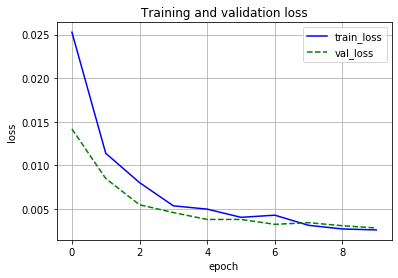

In [17]:
plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

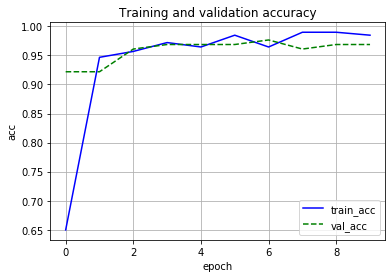

In [18]:
plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

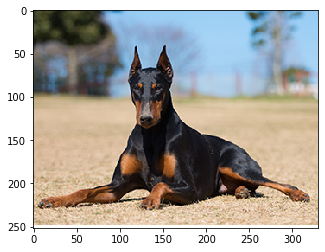

In [20]:
from PIL import Image
image_file_path = 'Doberman1.jpg'

img = Image.open(image_file_path)
plt.imshow(img)
plt.show()

In [21]:
# リサイズする
img_transformed = transform(img)
img_transformed.size()

torch.Size([3, 224, 224])

In [22]:
# モデルに合わせてさらに変形
inputs = img_transformed.unsqueeze_(0)
inputs.size()

torch.Size([1, 3, 224, 224])

In [23]:
outputs = model(inputs.cuda())
pred = torch.argmax(outputs, dim=1)
if pred == 0:
    print('Chihuahua')
elif pred == 1:
    print('Doberman')
elif pred == 2:
    print('Irish_wolfhound')

Doberman
